# Deep Reinforcement learning - Training an Agent to Solve Unity-ML Tennis environment using MultiAgent DDPG algorithm
---

This notebook presents the code to train a Deep RL Agent to solve the Unity ML-Agent Tennis environment. The training uses Multi Agent Deep Deterministic Policy Gradient algorithm.

### 1. Import the packages and Start the Environment


In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from deep_rl.agent.DDPG_agent import DDPGAgent

In [2]:
# Tennis environment. In this environment, two agents control rackets to bounce a ball over a net.
env = UnityEnvironment(file_name="Tennis.app") #In mac

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

print(brain.vector_observation_space_size)
print(state_size)
print(brain.vector_action_space_size)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
8
24
2


### 3. Training

In [5]:
# create a new agent
agent = DDPGAgent(state_size=state_size, action_size=brain.vector_action_space_size, random_seed=1)

In [6]:
#Just for debug/display purpose
print(state_size)

24


In [7]:
#Just for debug/display purpose
actions = np.random.randn(num_agents, action_size)
print(actions)

[[-1.62329803 -1.78604795]
 [-0.03083499  1.22016808]]


In [8]:
#Just for debug/display purpose
noise_factor = 0.1
env_info = env.reset(train_mode=True)[brain_name]
states = env_info.vector_observations
print(states)
print(states.shape)
actions = agent.act(states, noise_factor=noise_factor)
print(actions)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -7.38993645 -1.5
  -0.          0.          6.83172083  5.99607611 -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.70024681 -1.5
   0.          0.         -6.83172083  5.99607611  0.          0.        ]]
(2, 24)
[[ 0.03440508 -0.00063448]
 [ 0.04507908 -0.01415111]]


/Users/tamoghnadas/opt/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [6]:
def train_maddpg(n_episodes=3000, max_t=10000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    noise_factor = 0.1  # A factor to multiply random noise
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations # states.shape is (2,24). env_reset returned state of both tennis players
        scores_agents = np.zeros(2)  # the scores of both tennis agents after an episode
        agent.reset()
        for t in range(max_t):
            
            # The Agent selects Actions
            # actions for both the agents (both tennis players)
            if i_episode < 100:
                actions = np.random.randn(num_agents, action_size)  # use random actions for the first 100 episodes
            else:
                actions = agent.act(states, noise_factor=noise_factor)
            
            # Actions of the other player
            actions_other_player = np.flip(actions, 0)
            
            # Environment processes the Action; produces new State, Rewards
            env_info = env.step(actions)[brain_name]      
            rewards = env_info.rewards                    
            next_states = env_info.vector_observations
            next_states_other_player = np.flip(next_states, 0)
            dones = env_info.local_done 
            
            # The Agent learns
            #agent.step(states, actions, rewards, next_states, dones)
            agent.step(states, actions, actions_other_player, rewards, next_states, next_states_other_player, dones) 
            
            states = next_states
            scores_agents += rewards
            if np.any(dones):
                break 
        avg_score = np.mean(scores_agents)  # the average score of the agents
        max_score = np.max(scores_agents)  # the max score of the agents
        #scores_deque.append(avg_score)
        scores_deque.append(max_score)
        #scores.append(avg_score)
        scores.append(max_score)
        
        #noise reduced during training as episodes progresses
        noise_factor = max(0.995 * noise_factor, 0.01)
        
        #print('\rEpisode {:d}\tscore: {:.2f}\taverage score over the last 10 episodes: {:.2f}'.format(i_episode, scores_deque[-1], np.mean(list(scores_deque)[-10:])), end="")
        print('\rEpisode {:d}\tmax score: {:.2f}\tavg max score over the last 10 episodes: {:.2f}'.format(i_episode, scores_deque[-1], np.mean(list(scores_deque)[-10:])), end="")
        #if i_episode % 10 == 0:
            #torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor_{:d}_{:.2f}.pth'.format(i_episode, scores_deque[-1]))
            #torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic_{:d}_{:.2f}.pth'.format(i_episode, scores_deque[-1]))
        if i_episode > 100 and np.mean(scores_deque) > 0.5:
            torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAvg Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = train_maddpg()

Episode 100	Avg Score: 0.02	avg max score over the last 10 episodes: 0.01
Episode 200	Avg Score: 0.01	avg max score over the last 10 episodes: 0.00
Episode 300	Avg Score: 0.02	avg max score over the last 10 episodes: 0.02
Episode 400	Avg Score: 0.05	avg max score over the last 10 episodes: 0.09
Episode 500	Avg Score: 0.06	avg max score over the last 10 episodes: 0.02
Episode 600	Avg Score: 0.06	avg max score over the last 10 episodes: 0.09
Episode 700	Avg Score: 0.10	avg max score over the last 10 episodes: 0.11
Episode 800	Avg Score: 0.16	avg max score over the last 10 episodes: 0.11
Episode 900	Avg Score: 0.31	avg max score over the last 10 episodes: 1.31
Episode 917	max score: 2.60	avg max score over the last 10 episodes: 1.66
Environment solved in 817 episodes!	Average Score: 0.50


In [7]:
#close the environment
env.close()

## 4. Plot Score vs Episode#

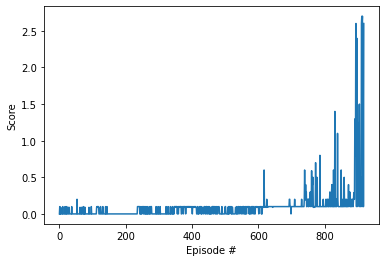

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()